<a href="https://colab.research.google.com/github/mequanent/App-Recommendation-Exercises/blob/main/Chapter%201%20-%20Mining%20Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mining Twitter

Twitter implements OAuth 1.0A as its standard authentication mechanism, and in order to use it to make requests to Twitter's API, you'll need to go to https://developer.twitter.com/en/apps and create a sample application. It is possible that Twitter no longer supports sandboxed applications and you may need to submit a request for permission to develop an app on Twitter.

There are four primary identifiers you'll need to note for an OAuth 1.0A workflow: consumer key, consumer secret, access token, and access token secret. Note that you will need an ordinary Twitter account in order to login, create an app, and get these credentials.

<img src="https://github.com/mequanent/App-Recommendation-Exercises/blob/main/resources/ch01-twitter/images/Twitter-AppCredentials.png?raw=1" width="600px">

If you are running this code on Binder or from the Docker container, you should just be able to execute the code in this notebook without any worries whatsoever about installing dependencies. If you are running the code from your own development envioronment, however, be advised that these examples in this chapter take advantage of a Python package called [twitter](https://github.com/sixohsix/twitter) to make API calls. You can install this package in a terminal with [pip](https://pypi.python.org/pypi/pip) with the command `pip install twitter`, preferably from within a [Python virtual environment](https://pypi.python.org/pypi/virtualenv). 

Once installed, you should be able to open up a Python interpreter (or better yet, your [IPython](http://ipython.org/) interpreter) and get rolling.

## Authorizing an application to access Twitter account data

In [2]:
pip install twitter -q

     |████████████████████████████████| 50 kB 4.6 MB/s 


In [3]:
import twitter

# Go to https://developer.twitter.com/en/apps to create an app and get values
# for these credentials, which you'll need to provide in place of these
# empty string values that are defined as placeholders.
# See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
# for more information on Twitter's OAuth implementation.

CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print(twitter_api)

## Retrieving trends

In [4]:
# The Yahoo! Where On Earth ID for the entire world is 1.
# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/

WORLD_WOE_ID = 1
US_WOE_ID = 23424977

# Prefix ID with the underscore for query string parameterization.
# Without the underscore, the twitter package appends the ID value
# to the URL itself as a special case keyword argument.

world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID)
us_trends = twitter_api.trends.place(_id=US_WOE_ID)

print(world_trends)
print()
print(us_trends)

[{'trends': [{'name': '#ProofOfInspiration1', 'url': 'http://twitter.com/search?q=%23ProofOfInspiration1', 'promoted_content': None, 'query': '%23ProofOfInspiration1', 'tweet_volume': 161718}, {'name': 'Pat Bev', 'url': 'http://twitter.com/search?q=%22Pat+Bev%22', 'promoted_content': None, 'query': '%22Pat+Bev%22', 'tweet_volume': 13711}, {'name': '#恋マジ', 'url': 'http://twitter.com/search?q=%23%E6%81%8B%E3%83%9E%E3%82%B8', 'promoted_content': None, 'query': '%23%E6%81%8B%E3%83%9E%E3%82%B8', 'tweet_volume': 63576}, {'name': '#CaratSelcaDay', 'url': 'http://twitter.com/search?q=%23CaratSelcaDay', 'promoted_content': None, 'query': '%23CaratSelcaDay', 'tweet_volume': 101234}, {'name': '#ラニバ1曲目予想', 'url': 'http://twitter.com/search?q=%23%E3%83%A9%E3%83%8B%E3%83%901%E6%9B%B2%E7%9B%AE%E4%BA%88%E6%83%B3', 'promoted_content': None, 'query': '%23%E3%83%A9%E3%83%8B%E3%83%901%E6%9B%B2%E7%9B%AE%E4%BA%88%E6%83%B3', 'tweet_volume': 11372}, {'name': '#身長マイナス体重は110がベストらしい', 'url': 'http://twitter.com/

In [5]:
for trend in world_trends[0]['trends']:
    print(trend['name'])

#ProofOfInspiration1
Pat Bev
#恋マジ
#CaratSelcaDay
#ラニバ1曲目予想
#身長マイナス体重は110がベストらしい
CANSAR DE DANÇAR NO YTB
Benedict
ARTHUR NO ENCONTRO
TE AMAMOS ARTHUR
Heizou
BRI Liga 1
Colin
Ubisoft
サルゲッチュ
Can Sevinç
GOT7 COMEBACK
すばるくん
Haftanın Yalanları
Penelope
PS Plus
ニュースZERO
PlayStation Plus
Black Mirror
ARIA MV TEASER
Iron Giant
SEEDs24
VAGABUNDO DA REPÚBLICA
OhmNanon
First Take
DREAM SQUAD STUDIO 4
全53公演
Liz Cheney
jaehyun
Sophie
La Liga
sky合コン
MV解禁
ウルトラマンZ
Bias Wrecker
Fav Bside
Predator
松丸くん
公式マーク
Fav Title Track
フルサイズ
商標登録
Patrick Beverly
Martha Karua
#花丸特番配信中


In [6]:
for trend in us_trends[0]['trends']:
    print(trend['name'])

Pat Bev
#mondaythoughts
#MondayMotivation
#DeppHeardTrial
First Take
#JusticeForJohhnyDepp
#ProofOfInspiration1
Liz Cheney
Patrick Beverly
Iron Giant
Daily Quordle 112
Get Up
Big Tech
Jaire
Waukesha
Benedict
Fauci
Ubisoft
Elaine
Camille
Penelope
Predator
Colin
Great Replacement Theory
Black Mirror
PlayStation Plus
Heizou
Ultra Instinct Shaggy
Elise
Ape Escape
PS Plus
Gorillaz
Uniqlo
Cara Delevingne
PS Now
New Week
San Junipero
Trump 2024
Another Monday
BMTH
Payroll
Syphon Filter
Every Monday
Happy 20th
Jim Acosta
Neil deGrasse Tyson
Drew Brees
jaehyun
Rachel Maddow
Anemo


In [7]:
world_trends_set = set([trend['name'] 
                        for trend in world_trends[0]['trends']])

us_trends_set = set([trend['name'] 
                     for trend in us_trends[0]['trends']]) 

common_trends = world_trends_set.intersection(us_trends_set)

print(common_trends)

{'Heizou', 'First Take', 'Black Mirror', 'Patrick Beverly', 'Predator', 'Ubisoft', 'Liz Cheney', 'jaehyun', 'Benedict', 'Penelope', 'Colin', '#ProofOfInspiration1', 'PS Plus', 'Pat Bev', 'PlayStation Plus', 'Iron Giant'}


## Anatomy of a Tweet

In [8]:
import json

# Set this variable to a trending topic, 
# or anything else for that matter. The example query below
# was a trending topic when this content was being developed
# and is used throughout the remainder of this chapter.

q = '#MothersDay' 

count = 100

# Import unquote to prevent url encoding errors in next_results
from urllib.parse import unquote

# See https://dev.twitter.com/rest/reference/get/search/tweets

search_results = twitter_api.search.tweets(q=q, count=count)

statuses = search_results['statuses']


# Iterate through 5 more batches of results by following the cursor
for _ in range(5):
    print('Length of statuses', len(statuses))
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError as e: # No more results when next_results doesn't exist
        break
        
    # Create a dictionary from next_results, which has the following form:
    # ?max_id=847960489447628799&q=%23RIPSelena&count=100&include_entities=1
    kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]).split("&") ])
    
    search_results = twitter_api.search.tweets(**kwargs)
    statuses += search_results['statuses']

# Show one sample search result by slicing the list...
print(json.dumps(statuses[0], indent=1))

Length of statuses 94
Length of statuses 194
Length of statuses 287
Length of statuses 383
Length of statuses 477
{
 "created_at": "Mon May 16 14:56:54 +0000 2022",
 "id": 1526215118228443136,
 "id_str": "1526215118228443136",
 "text": "https://t.co/ANVIUV5YsS \n#brooch #vintage #large #spray #floral #berries #pink #orange #leaves #enamel #coral\u2026 https://t.co/LGG2KzaUIE",
 "truncated": true,
 "entities": {
  "hashtags": [
   {
    "text": "brooch",
    "indices": [
     25,
     32
    ]
   },
   {
    "text": "vintage",
    "indices": [
     33,
     41
    ]
   },
   {
    "text": "large",
    "indices": [
     42,
     48
    ]
   },
   {
    "text": "spray",
    "indices": [
     49,
     55
    ]
   },
   {
    "text": "floral",
    "indices": [
     56,
     63
    ]
   },
   {
    "text": "berries",
    "indices": [
     64,
     72
    ]
   },
   {
    "text": "pink",
    "indices": [
     73,
     78
    ]
   },
   {
    "text": "orange",
    "indices": [
     79,
     86

In [9]:
for i in range(10):
    print()
    print(statuses[i]['text'])
    print('Favorites: ', statuses[i]['favorite_count'])
    print('Retweets: ', statuses[i]['retweet_count'])


https://t.co/ANVIUV5YsS 
#brooch #vintage #large #spray #floral #berries #pink #orange #leaves #enamel #coral… https://t.co/LGG2KzaUIE
Favorites:  0
Retweets:  0

Out of the oven and onto mom’s plate. Serve up all of her favorites this #MothersDay with #LGSTUDIO. #LGUS #LGFam… https://t.co/hr8RnSX8xe
Favorites:  0
Retweets:  0

RT @SudhaRamenIFS: The purest form of love ❤️
 #MothersDay wishes https://t.co/YZWFHEyZmb
Favorites:  0
Retweets:  590

Mi mamá es genial! #CoffeeMOMentsTCC #TheCoffeeCup
😘👱‍♀️👩‍🦳👩‍🦰❤️☕️
#mothersday #CoffeeShop #tea #teatime #TheBest… https://t.co/hjWl2UKluU
Favorites:  0
Retweets:  0

Check out this awesome 'NAMASTE' design on @TeePublic! https://t.co/0gEzdIwZ5E Very funny alternative printed gifts… https://t.co/vmpEnGf0Am
Favorites:  0
Retweets:  0

RT @yunijewels: Gray Rose Cut Diamond Wedding Ring Silver #etsy #jewelry #rings #diamonds #weddingring #Anniversary #Rosecutdiamondring #si…
Favorites:  0
Retweets:  2

RT @nsaidian: Mother 
Is
Another 
Word For 


## Extracting text, screen names, and hashtags from tweets

In [10]:
status_texts = [ status['text'] 
                 for status in statuses ]

screen_names = [ user_mention['screen_name'] 
                 for status in statuses
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text'] 
             for status in statuses
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w 
          for t in status_texts 
              for w in t.split() ]

# Explore the first 5 items for each...

print(json.dumps(status_texts[0:5], indent=1))
print(json.dumps(screen_names[0:5], indent=1) )
print(json.dumps(hashtags[0:5], indent=1))
print(json.dumps(words[0:5], indent=1))

[
 "https://t.co/ANVIUV5YsS \n#brooch #vintage #large #spray #floral #berries #pink #orange #leaves #enamel #coral\u2026 https://t.co/LGG2KzaUIE",
 "Out of the oven and onto mom\u2019s plate. Serve up all of her favorites this #MothersDay with #LGSTUDIO. #LGUS #LGFam\u2026 https://t.co/hr8RnSX8xe",
 "RT @SudhaRamenIFS: The purest form of love \u2764\ufe0f\n #MothersDay wishes https://t.co/YZWFHEyZmb",
 "Mi mam\u00e1 es genial! #CoffeeMOMentsTCC #TheCoffeeCup\n\ud83d\ude18\ud83d\udc71\u200d\u2640\ufe0f\ud83d\udc69\u200d\ud83e\uddb3\ud83d\udc69\u200d\ud83e\uddb0\u2764\ufe0f\u2615\ufe0f\n#mothersday #CoffeeShop #tea #teatime #TheBest\u2026 https://t.co/hjWl2UKluU",
 "Check out this awesome 'NAMASTE' design on @TeePublic! https://t.co/0gEzdIwZ5E Very funny alternative printed gifts\u2026 https://t.co/vmpEnGf0Am"
]
[
 "SudhaRamenIFS",
 "TeePublic",
 "yunijewels",
 "nsaidian",
 "Ozge_Torer"
]
[
 "brooch",
 "vintage",
 "large",
 "spray",
 "floral"
]
[
 "https://t.co/ANVIUV5YsS",
 "#brooch",
 

## Creating a basic frequency distribution from the words in tweets

In [11]:
from collections import Counter

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10
    print()

[('RT', 448), ('#MothersDay', 189), ('to', 163), ('the', 161), ('of', 125), ('a', 124), ('and', 103), ('for', 64), ('Happy', 55), ('is', 54)]

[('GrandmasDowry', 22), ('eBay', 21), ('TelanganaCOPs', 20), ('hailewdihaweza', 11), ('nsaidian', 10), ('Gurmeetramrahim', 10), ('itachi_senpai1', 10), ('FfdfGsdd', 10), ('SadhguruJV', 9), ('gaspardromain3', 8)]

[('MothersDay', 241), ('mothersday', 49), ('giftformom', 24), ('white', 22), ('birthdayGift', 22), ('giftforher', 22), ('midcentury', 22), ('clips', 22), ('etsy', 21), ('InternationalDayofFamilies', 20)]



## Using prettytable to display tuples in a nice tabular format

In [12]:
from prettytable import PrettyTable

for label, data in (('Word', words), 
                    ('Screen Name', screen_names), 
                    ('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count']) 
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:10] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+-------------+-------+
| Word        | Count |
+-------------+-------+
| RT          |   448 |
| #MothersDay |   189 |
| to          |   163 |
| the         |   161 |
| of          |   125 |
| a           |   124 |
| and         |   103 |
| for         |    64 |
| Happy       |    55 |
| is          |    54 |
+-------------+-------+
+-----------------+-------+
| Screen Name     | Count |
+-----------------+-------+
| GrandmasDowry   |    22 |
| eBay            |    21 |
| TelanganaCOPs   |    20 |
| hailewdihaweza  |    11 |
| nsaidian        |    10 |
| Gurmeetramrahim |    10 |
| itachi_senpai1  |    10 |
| FfdfGsdd        |    10 |
| SadhguruJV      |     9 |
| gaspardromain3  |     8 |
+-----------------+-------+
+----------------------------+-------+
| Hashtag                    | Count |
+----------------------------+-------+
| MothersDay                 |   241 |
| mothersday                 |    49 |
| giftformom                 |    24 |
| white                      |    22 |

## Calculating lexical diversity for tweets

In [13]:
# A function for computing lexical diversity
def lexical_diversity(tokens):
    return len(set(tokens))/len(tokens) 

# A function for computing the average number of words per tweet
def average_words(statuses):
    total_words = sum([ len(s.split()) for s in statuses ]) 
    return total_words/len(statuses)

print(lexical_diversity(words))
print(lexical_diversity(screen_names))
print(lexical_diversity(hashtags))
print(average_words(status_texts))

0.37110909640374734
0.5415282392026578
0.39082819986310746
17.53886925795053


## Finding the most popular retweets

In [14]:
retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in statuses 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:5] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)

+-------+-------------+---------------------+----------------------------------------------------+
| Count | Screen Name | Tweet ID            | Text                                               |
+-------+-------------+---------------------+----------------------------------------------------+
| 33459 | layzhang    | 1523173762434502656 | RT @layzhang: Happy Mother’s Day! I wish mothers   |
|       |             |                     | all over the world a happy holiday. You will       |
|       |             |                     | always be the most beautiful, powerful, and g…     |
| 33459 | layzhang    | 1523173762434502656 | RT @layzhang: Happy Mother’s Day! I wish mothers   |
|       |             |                     | all over the world a happy holiday. You will       |
|       |             |                     | always be the most beautiful, powerful, and g…     |
| 22344 | peanuts_omr | 1522956632531279872 | RT @peanuts_omr: #SPY_FAMILY #MothersDay           |
|       | 

## Looking up users who have retweeted a status

In [15]:
# Get the original tweet id for a tweet from its retweeted_status node 
# and insert it here

_retweets = twitter_api.statuses.retweets(id=862359093398261760)
print([r['user']['screen_name'] for r in _retweets])

['vijoumolce1988', 'driftourare1988', 'ShinobiSasha', 'livingmybestie', 'Rockawaytheday']


## Plotting frequencies of words

Text(0.5, 0, 'Word Rank')

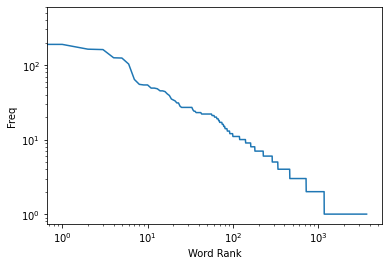

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
word_counts = sorted(Counter(words).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

## Generating histograms of words, screen names, and hashtags

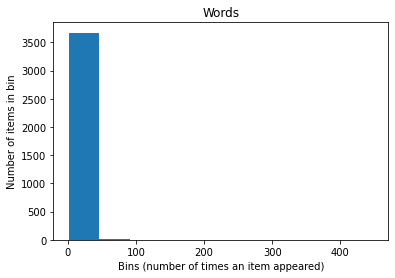

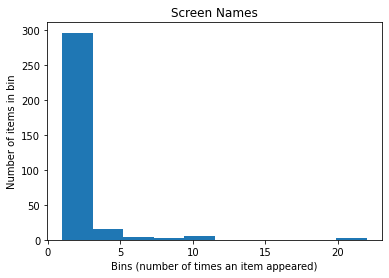

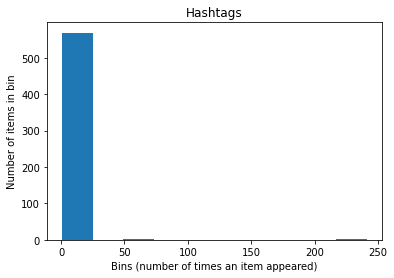

<Figure size 432x288 with 0 Axes>

In [17]:
for label, data in (('Words', words), 
                    ('Screen Names', screen_names), 
                    ('Hashtags', hashtags)):

    # Build a frequency map for each set of data
    # and plot the values
    c = Counter(data)
    plt.hist(list(c.values()))
    
    # Add a title and y-label ...
    plt.title(label)
    plt.ylabel("Number of items in bin")
    plt.xlabel("Bins (number of times an item appeared)")
    
    # ... and display as a new figure
    plt.figure()

## Generating a histogram of retweet counts

Text(0, 0.5, 'Number of tweets in bin')

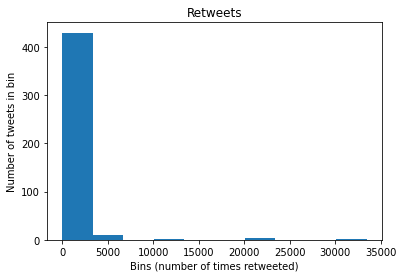

In [18]:
# Using underscores while unpacking values in
# a tuple is idiomatic for discarding them

counts = [count for count, _, _, _ in retweets]

plt.hist(counts)
plt.title('Retweets')
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

## Sentiment Analysis

In [19]:
pip install twython -q

In [20]:
# pip install nltk
# pip install twython
import nltk
nltk.download('vader_lexicon')

import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [22]:
twitter_stream = twitter.TwitterStream(auth=auth)
iterator = twitter_stream.statuses.sample()

In [ ]:
tweets = []
for tweet in iterator:
    try:
        if tweet['lang'] == 'en':
            tweets.append(tweet)
    except:
        pass
    if len(tweets) == 100:
        break

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
analyzer.polarity_scores('Hello')

In [ ]:
analyzer.polarity_scores('I really enjoy this video series.')

In [ ]:
analyzer.polarity_scores('I REALLY enjoy this video series.')

In [ ]:
analyzer.polarity_scores('I REALLY enjoy this video series!!!')

In [ ]:
analyzer.polarity_scores('I REALLY did not enjoy this video series!!!')

In [ ]:
scores = np.zeros(len(tweets))

for i, t in enumerate(tweets):
    # Extract the text portion of the tweet
    text = t['text']
    
    # Measure the polarity of the tweet
    polarity = analyzer.polarity_scores(text)
    
    # Store the normalized, weighted composite score
    scores[i] = polarity['compound']

In [ ]:
most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

In [ ]:
print('{0:6.3f} : "{1}"'.format(scores[most_positive], tweets[most_positive]['text']))

In [ ]:
print('{0:6.3f} : "{1}"'.format(scores[most_negative], tweets[most_negative]['text']))